In [27]:
import sys
sys.path.insert(0, '../util')
sys.path.insert(0, '../')
import matplotlib.pyplot as plt
from sc import *
from plot import *
from tqdm import tqdm
from alg import hstar, k_rollout, bhattacharya, almost_equal
from pqdict import pqdict
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

In [28]:
def manual_sc_set(K, simps):
    K.nodes, K.edges, K.faces = simps
    K.num_nodes, K.num_edges, K.num_faces = [len(x) for x in simps]
    K.node_vec = np.zeros(K.num_nodes, dtype=int)
    K.edge_vec = np.zeros(K.num_edges, dtype=int)
    K.face_vec = np.zeros(K.num_faces, dtype=int)
    K.B0_main, K.B1_main = K.make_boundaries()
    K.add_simplices({2:np.arange(K.num_faces)})
    K.update_nodes()
    return K

In [29]:
from scipy.spatial import Delaunay
pts = np.array([(-1, 0), (0,np.sqrt(3)), (0, -1), (1, 0)])
num_nodes = len(pts)

In [30]:
nodes, faces = pts, list(Delaunay(pts).simplices)
edge_idx_dict, edge_dict = {}, {}
num_edge = 0

for face in faces:
    n1, n2, n3 = sorted(face)
    face_edges = [(n1, n2), (n1, n3), (n2, n3)]

    for edge in face_edges:
        if edge not in edge_dict:
            edge_dict[edge] = num_edge
            edge_idx_dict[num_edge] = edge
            num_edge += 1

edges = [edge_idx_dict[i] for i in range(num_edge)]
faces = [tuple(sorted(face)) for face in faces]

In [32]:
SC = SimplicialComplex(2, random=False)
simps = nodes, edges, faces
SC = manual_sc_set(SC, simps)
SC.del_simplices({2:[0]})

<AxesSubplot:>

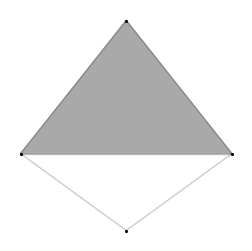

In [34]:
plot_sc(SC, figsize=(3,3))

In [ ]:
def plot_bases(SC, font=None, figsize=(5,5), arrowmult=7, node_size=5, edgemult=1, edge_color="blue", node_color='gray'):
    if font is None:
        font = {'family': 'serif',
            'color':  'black',
            'weight': 'normal',
            'size': 16,
            }
    node_pos = {i:SC.nodes[i] for i in (np.where(SC.node_vec == 1)[0])}
    num_bases = SC.H.shape[0]
    
    for i in range(num_bases):
        harm_vec = SC.H[i,:]
        harm_vec_sign = np.sign(harm_vec)
        harm_vec_weight = np.abs(harm_vec)
        G_oriented = nx.DiGraph()
        j = 0
        for k, edge in enumerate(SC.edges):
            if not SC.edge_vec[k]:
                continue
            sign, weight = harm_vec_sign[j], harm_vec_weight[j] * 10
            # oriented_edge = (edge[0], edge[1]) if (sign > 0) else (edge[1], edge[0])
            oriented_edge = edge
            G_oriented.add_edge(oriented_edge[0], oriented_edge[1], weight=weight)
            j += 1

        oriented_weights = [G_oriented[u][v]['weight']*edgemult for u,v in G_oriented.edges]
        plt.figure(figsize=figsize)
        ax = plt.gca()

        for j, face in enumerate(SC.faces):
            #alpha_val = 0 if self.face_vec[i] else 0.2
            #color = 'white' if self.face_vec[i] else 'darkgray'
            if SC.face_vec[j]:
                continue
            color = 'darkgray'
            n1, n2, n3 = face
            tri = np.vstack([SC.nodes[n1], SC.nodes[n2], SC.nodes[n3]])
            ti = plt.Polygon(tri, color=color, alpha=1)
            ax.add_patch(ti)

        nx.draw(G_oriented, pos=node_pos, node_size=node_size, node_color=node_color, width=oriented_weights, edge_color=edge_color, arrows=True, arrowstyle='-|>', arrowsize=[arrowmult * i for i in oriented_weights])

        # plt.title(f"Harmonic Basis Vector $h_{i+1}$", fontdict=font)
        plt.show()

In [35]:
v1, v2, v3, v4 = pts
coords_list = [[v1, v2, v4], [v1, v4], [v1, v3, v4]]
paths =  [path_from_coords(SC, coords_i) for coords_i in coords_list]

<AxesSubplot:>

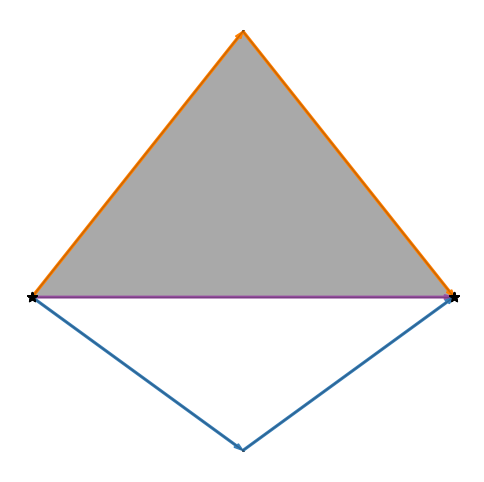

In [36]:
colors = ['#4daf4a', '#984ea3', '#f781bf', '#ff7f00', '#377eb8', '#ff7f00', '#a65628', '#999999', '#e41a1c', '#dede00']

several_path_plot(SC, paths, colors = [colors[3], colors[1], colors[4]], figsize=(1,1))

In [37]:
print(nodes)
print(SC.edges)

[[-1.          0.        ]
 [ 0.          1.73205081]
 [ 0.         -1.        ]
 [ 1.          0.        ]]
[(0, 1), (0, 3), (1, 3), (0, 2), (2, 3)]


In [45]:
SC.H = SC.H / np.abs(SC.H[0,4])

In [46]:
ref_coords = [(-1,0), (0, 2), (1,0)]
ref_path = Path(SC, path_from_coords(SC, ref_coords))

In [47]:
path1, _, _, _, _ = hstar(SC, ref_path, 0)
alpha_star = (ref_path.weight - path1.weight) / np.linalg.norm(path1.proj - ref_path.proj)
path2, _, _, _, _ = hstar(SC, ref_path, alpha_star + 1e-2)

In [48]:
alpha_star

0.24999999999999983

In [49]:
hstar(SC, ref_path, 1.42)

(0-1-3,
 3.9999999999999996,
 {1: 0, 3: 1, 2: 0},
 [(0, array([0.])), (1, array([3.])), (3, array([6.]))],
 [])

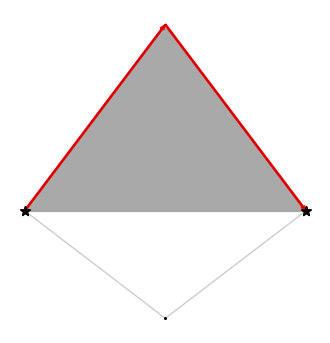

In [60]:
plot_path(SC, ref_path, 'red', label=None, figsize=(4,4.2))
plt.show()

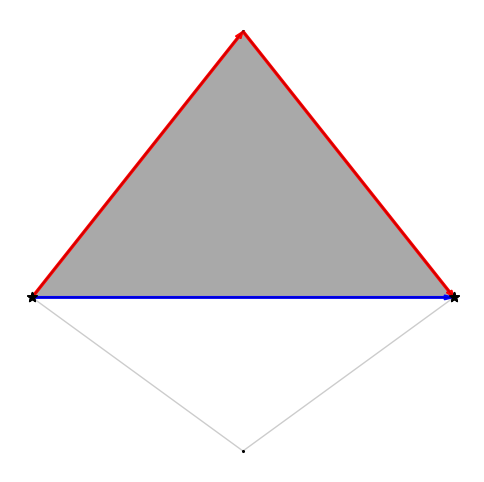

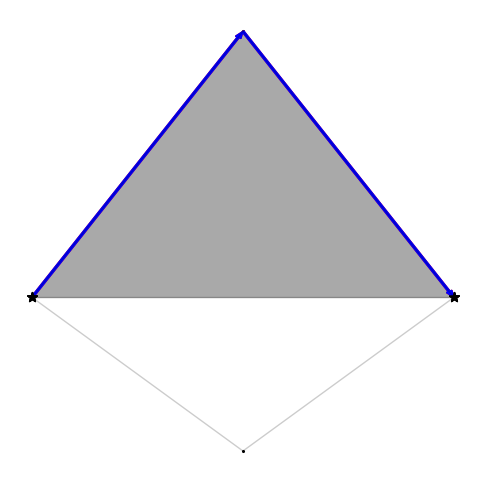

In [59]:
several_path_plot(SC, [ref_path, path1], colors=['red', 'blue'], figsize=(4,4.2))
plt.show()
several_path_plot(SC, [ref_path, path2], colors=['red', 'blue'])
plt.show()

In [ ]:
(path1 + -path2) + (path1 + -path2)